# Temperature Prediction

Predict the **temperature** based on humidity data.


In [192]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle as pkl
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
warnings.filterwarnings("ignore")

In [208]:
# Load the dataset
df = pd.read_csv("humidity.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701548 entries, 0 to 701547
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    701548 non-null  int64  
 1   lat          701548 non-null  float64
 2   lon          701548 non-null  float64
 3   pressure     701548 non-null  float64
 4   temperature  701548 non-null  float64
 5   humidity     701548 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 32.1 MB


,sensor_id,lat,lon,pressure,temperature,humidity
0,2266,42.738,23.272,95270.27,23.46,62.48
1,2292,42.663,23.273,94355.83,23.06,59.46
2,3096,42.700,23.360,95155.81,26.53,44.38
3,3428,42.624,23.406,94679.57,28.34,38.28
4,3472,42.669,23.318,94327.88,26.31,46.37


## Exploratory Data Analysis


In [209]:
# Check for duplicate values
df.duplicated().sum()

np.int64(4035)

In [210]:
# Remove duplicate rows
df = df.drop_duplicates()

In [211]:
# Display summary statistics
df.describe()

,sensor_id,lat,lon,pressure,temperature,humidity
count,697513.000000,697513.000000,697513.000000,697513.000000,697513.000000,697513.000000
mean,2839.111059,42.679680,23.333633,94878.877607,25.675188,48.090655
std,797.635396,0.025633,0.039450,761.642105,6.457013,20.599269
min,1764.000000,42.622000,23.240000,0.000000,-145.120000,0.000000
25%,2224.000000,42.664000,23.310000,94524.780000,20.700000,34.080000
50%,2607.000000,42.683000,23.332000,95001.390000,24.830000,48.210000
75%,3474.000000,42.694000,23.360000,95398.800000,29.910000,62.690000
max,4661.000000,42.738000,23.419000,164926.750000,61.170000,100.000000


In [212]:
#Number of unique sensors and their IDs
print("Number of unique sensors:", df['sensor_id'].nunique())
print("Unique sensor IDs:", df['sensor_id'].unique())

Number of unique sensors: 56
Unique sensor IDs: [2266 2292 3096 3428 3472 1952 1846 3512 2228 3438 1954 3620 3436 3092
 2036 1962 3474 2232 2607 2224 3738 3102 2040 2216 3432 2294 2230 2264
 1850 2234 3558 2262 1764 3836 2038 2323 3500 3326 3328 3968 3982 3296
 3642 3832 4358 4467 4469 4471 4473 4475 4477 4479 4558 4608 4625 4661]


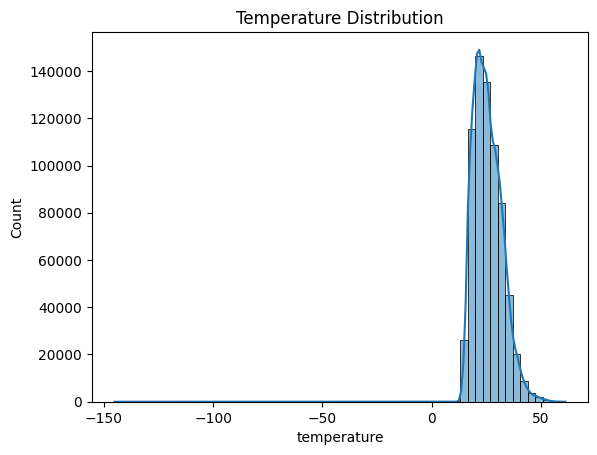

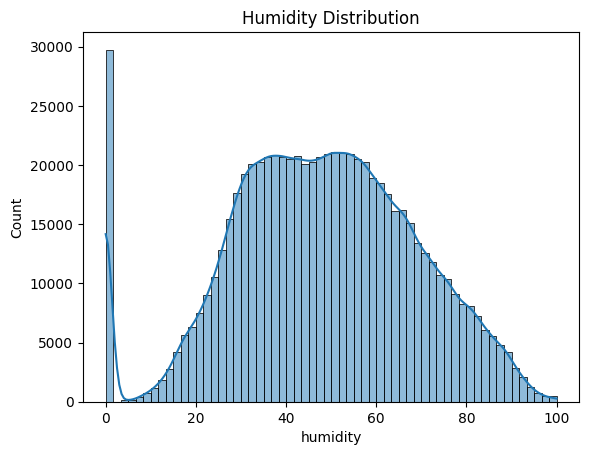

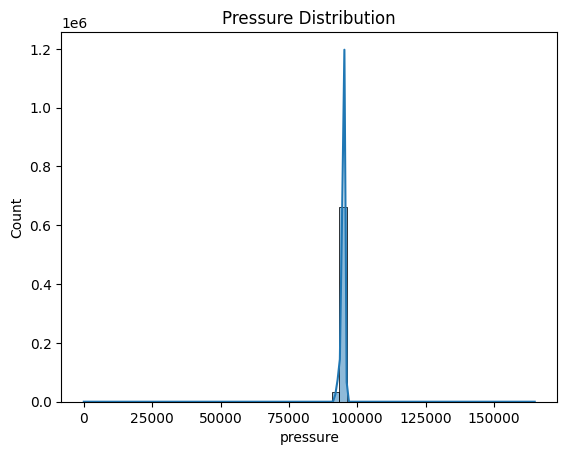

In [213]:
#plot distributions of numerical features
numerical_features = ['temperature', 'humidity', 'pressure']
for feature in numerical_features:
    sns.histplot(df[feature], bins=60, kde=True)
    plt.title(f'{feature.capitalize()} Distribution')
    plt.show()

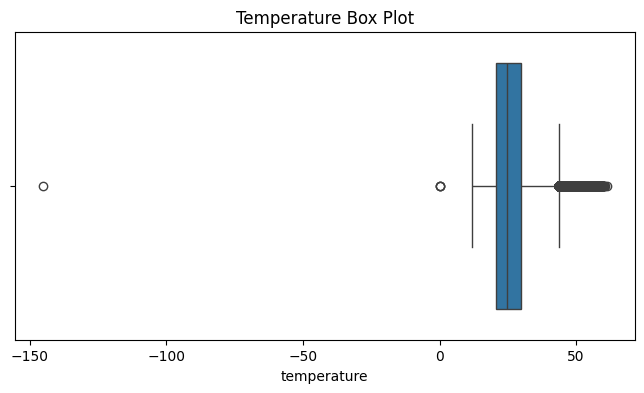

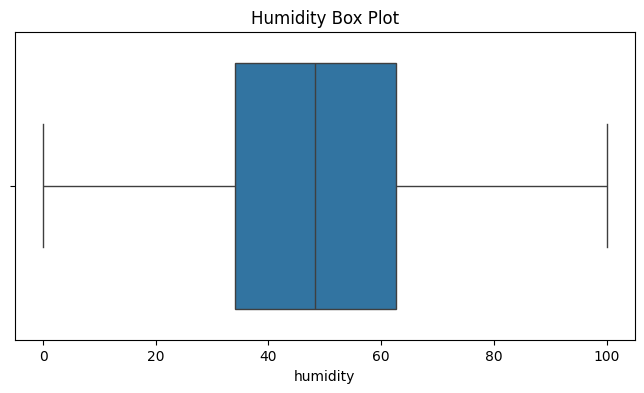

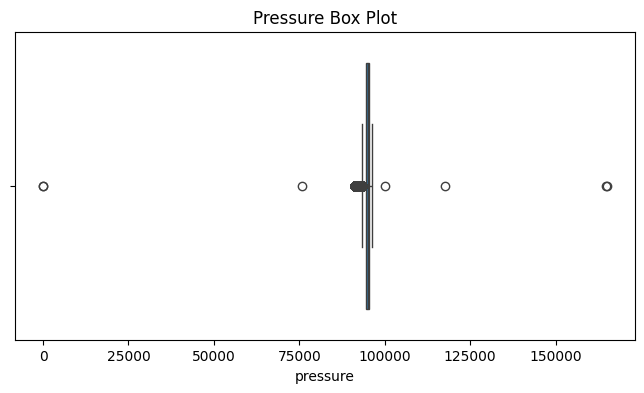

In [214]:
#Plot box plots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature])
    plt.title(f'{feature.capitalize()} Box Plot')
    plt.show()

In [215]:
#Find number of outliers using IQR method
for feature in numerical_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f'Number of outliers in {feature}: {outliers.shape[0]}')

Number of outliers in temperature: 6739
Number of outliers in humidity: 0
Number of outliers in pressure: 27594


In [216]:
# Function to identify outliers using IQR method
def outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    print(f'{feature} Lower_bound: {lower_bound}')
    upper_bound = Q3 + 1.5 * IQR
    print(f'{feature} Upper_bound: {upper_bound}')
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

temperature Lower_bound: 6.884999999999998
temperature Upper_bound: 43.725


,sensor_id,lat,lon,pressure,temperature,humidity
378151,4358,42.703,23.373,93213.75,6.884,0.0
531939,2040,42.686,23.351,96709.83,6.884,100.0
693615,3982,42.654,23.330,96709.83,6.884,0.0
693853,3982,42.654,23.330,93213.75,6.884,0.0


Number of unique values in temperature_outliers: 1
Minimum temperature outlier value: 6.884
Maximum temperature outlier value: 6.884


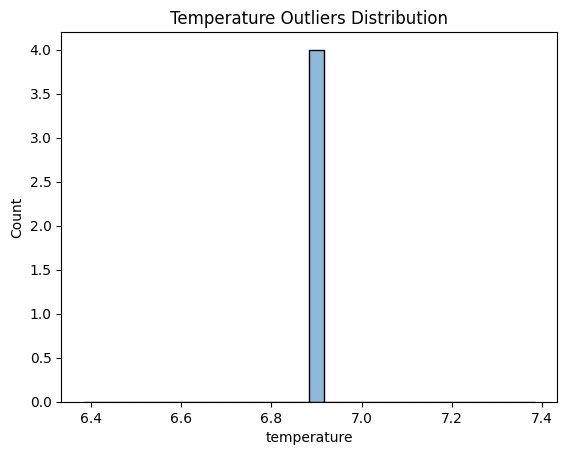

In [221]:
#Analyze temperature outliers
temperature_outliers=outliers(df, 'temperature')

display(temperature_outliers.head())
print('Number of unique values in temperature_outliers:', temperature_outliers['temperature'].nunique())
#print(temperature_outliers['temperature'].unique())
print('Minimum temperature outlier value:', temperature_outliers['temperature'].min())
print('Maximum temperature outlier value:', temperature_outliers['temperature'].max())
sns.histplot(temperature_outliers['temperature'], bins=30, kde=True)
plt.title('Temperature Outliers Distribution')
plt.show()

In [222]:
#Temperature outlier handling by capping
print('Number of low temperature outliers:', df[df['temperature']<=6.884].shape[0])
print('Number of high temperature outliers:', df[df['temperature']>=43.725].shape[0])
df.loc[df['temperature']<6.884,'temperature']=6.884
df.loc[df['temperature']>43.725,'temperature']=43.725

Number of low temperature outliers: 4
Number of high temperature outliers: 6735


pressure Lower_bound: 93213.75
pressure Upper_bound: 96709.83000000002
Number of unique values in pressure_outliers: 0
Minimum pressure outlier value: nan
Maximum pressure outlier value: nan


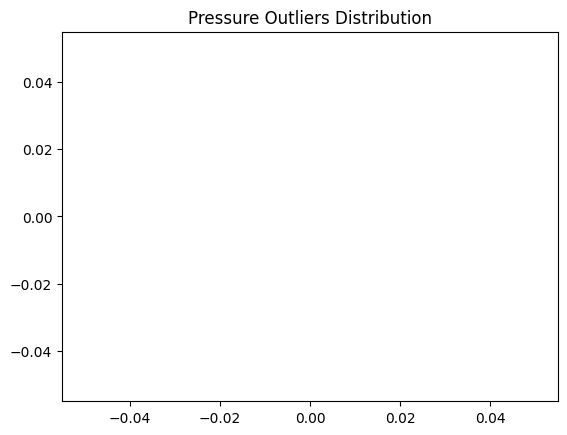

In [223]:
#Analyze pressure outliers
pressure_outliers=outliers(df, 'pressure')
#print('Unique values in pressure_outliers:', pressure_outliers['pressure'].unique())
print('Number of unique values in pressure_outliers:', pressure_outliers['pressure'].nunique())
print('Minimum pressure outlier value:', pressure_outliers['pressure'].min())
print('Maximum pressure outlier value:', pressure_outliers['pressure'].max())
sns.histplot(pressure_outliers['pressure'], bins=30, kde=True)
plt.title('Pressure Outliers Distribution')
plt.show()

In [224]:
#Pressure outlier handling by capping
print('Number of low pressure outliers:', df[df['pressure']<=93213.75].shape[0])
print('Number of high pressure outliers:', df[df['pressure']>=96709.83].shape[0])
df.loc[df['pressure']<93213.75,'pressure']=93213.75
df.loc[df['pressure']>96709.83,'pressure']=96709.83

Number of low pressure outliers: 27590
Number of high pressure outliers: 4


In [225]:
# Identify outliers using IQR method after capping
for feature in numerical_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f'Number of outliers in {feature}: {outliers.shape[0]}')

Number of outliers in temperature: 4
Number of outliers in humidity: 0
Number of outliers in pressure: 0


In [226]:
#Correlation
df.corr()

#Note : Pressure have very less correlation with temperature, so feature selected only humidity to predict temperature

,sensor_id,lat,lon,pressure,temperature,humidity
sensor_id,1.000000,0.094164,0.005409,0.016240,0.047726,-0.127871
lat,0.094164,1.000000,0.035303,0.601259,0.049258,0.059287
lon,0.005409,0.035303,1.000000,0.368187,0.027068,0.050724
pressure,0.016240,0.601259,0.368187,1.000000,-0.018192,0.002365
temperature,0.047726,0.049258,0.027068,-0.018192,1.000000,-0.777807
humidity,-0.127871,0.059287,0.050724,0.002365,-0.777807,1.000000


Text(0.5, 1.0, 'Humidity vs Temperature')

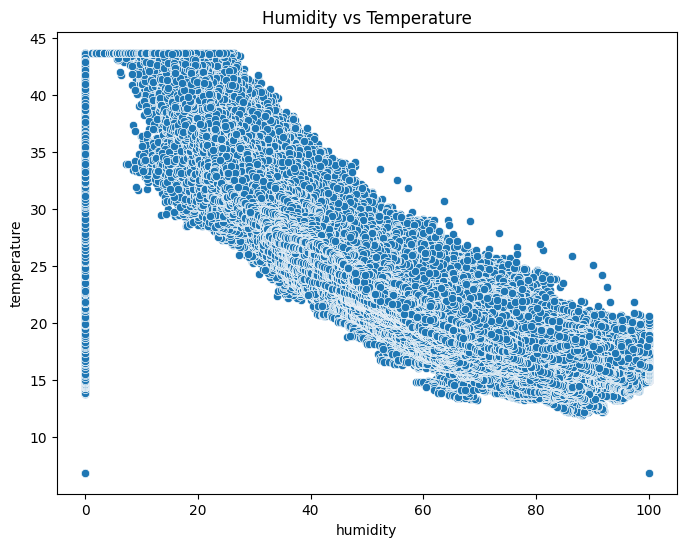

In [227]:
#Plot scatter plot for humidity vs temperature
plt.figure(figsize=(8, 6))
sns.scatterplot(x='humidity', y='temperature', data=df)
plt.title('Humidity vs Temperature')

In [228]:
#Drop rows where humidity is 0
print('Number of rows with humidity is equal to zero: ', df.loc[df['humidity']==0].shape[0])
df.drop(df[df['humidity']==0].index, inplace=True)

Number of rows with humidity is equal to zero:  29742


## Train test split

In [229]:

# Define features and target
X = df[['humidity']]   # feature
y = df['temperature']  # target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training

In [230]:
models = {
    'Linear_Regression': LinearRegression(),
    'Polynomial_Regression': Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
}

In [231]:
results = []
os.makedirs("Models", exist_ok=True)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    pkl.dump(model, open(f"Models/{name}.pkl", 'wb'))

    #Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R²': r2})

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)

# Display results
print(results_df)


                   Model       MAE      RMSE        R²
1  Polynomial_Regression  1.871664  2.312810  0.867856
0      Linear_Regression  2.163255  2.668754  0.824052


## Hyperparameter Tuning


In [232]:
from sklearn.model_selection import GridSearchCV
best_models={}
param_grids = {
    "Linear_Regression": {
        'fit_intercept': [True, False],
        'positive': [True, False]
    },
    "Polynomial_Regression": {
        'poly__degree': [2, 3, 4],
        'linear__fit_intercept': [True, False],
        'linear__positive': [True, False]
    }
}
for name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    
  # Replace the original model with the best model from the grid search
    best_models[name] = grid_search.best_estimator_

Best parameters for Linear_Regression: {'fit_intercept': True, 'positive': False}
Best parameters for Polynomial_Regression: {'linear__fit_intercept': False, 'linear__positive': False, 'poly__degree': 4}


In [233]:

#fit the above best hyper parameter and run the model again
results = []

# Train and evaluate each model with the best hyperparameters
for name, model in best_models.items():
    model.fit(X_train, y_train)  # Train the model
    pkl.dump(model, open(f'Models/{name}_tuned.pkl', 'wb'))
    y_pred = model.predict(X_test)  # Predict on test data

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2})

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)

# Display results
print(results_df)

                   Model       MAE      RMSE        R²
1  Polynomial_Regression  1.865947  2.308592  0.868337
0      Linear_Regression  2.163255  2.668754  0.824052


In [234]:
humidity=float(input("Enter the humidity:"))

for name,models in best_models.items():
  model=pkl.load(open(f'Models/{name}_tuned.pkl','rb'))
  temp=model.predict(np.array([[humidity]]))
  print(f'The predicted temperature for {name} is {temp}')

The predicted temperature for Linear_Regression is [21.7791484]
The predicted temperature for Polynomial_Regression is [21.10387949]
